In [50]:
import pymssql
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import sqlalchemy
from sqlalchemy  import create_engine
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from collections import Counter

In [6]:
############################### Database Connections ######################################
# AWS
#server = 'pfidb.ci3ir6nuotoi.sa-east-1.rds.amazonaws.com'
#user = 'admin'
#password = 'AramLucas2020.'
#db = 'pfidb'

# Local DB PC
server = 'DESKTOP-3OHRULK'
user = 'sa'
password = 'welcome1'
db = 'pfidb'

# Connection to DB
conn = pymssql.connect(server,user,password,db)

#Connection using sqlAlchemy
conn_for_insert = fr'mssql+pymssql://'+user+':'+password+'@'+server+'/'+db
engine = create_engine(conn_for_insert)

In [7]:
#Query that retrives the usage of the stations
# query = open("master_query_v3.sql","r")
# df_stations_usage = pd.read_sql_query(query.read(),conn)

stations_query = """SELECT * FROM [estaciones-de-bicicletas-publicas]"""
# stations_query = """SELECT * FROM [estaciones-bicicletas-publicas-2019]"""
df_stations = pd.read_sql(stations_query,conn)


In [11]:
coords = df_stations.as_matrix(columns=['lat', 'long'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


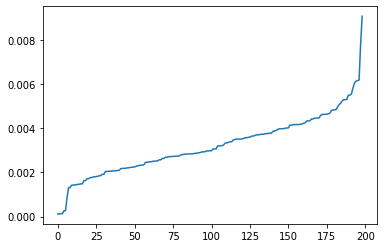

In [64]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(coords)
distances, indices = nbrs.kneighbors(coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [144]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian
# db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
db = DBSCAN(eps=0.00009, min_samples=1, algorithm='auto', metric='manhattan',leaf_size=10,).fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))
np.array(np.unique(cluster_labels, return_counts=True)).T

Number of clusters: 71


array([[ 0,  1],
       [ 1, 59],
       [ 2,  1],
       [ 3,  4],
       [ 4, 10],
       [ 5,  2],
       [ 6,  1],
       [ 7,  5],
       [ 8,  1],
       [ 9,  8],
       [10,  6],
       [11,  2],
       [12,  2],
       [13,  2],
       [14,  2],
       [15,  6],
       [16,  5],
       [17,  1],
       [18,  4],
       [19,  1],
       [20,  2],
       [21,  1],
       [22,  1],
       [23,  5],
       [24,  7],
       [25,  1],
       [26,  1],
       [27,  1],
       [28,  2],
       [29,  1],
       [30,  1],
       [31,  1],
       [32,  2],
       [33,  3],
       [34,  1],
       [35,  2],
       [36,  1],
       [37,  1],
       [38,  1],
       [39,  2],
       [40,  1],
       [41,  2],
       [42,  1],
       [43,  1],
       [44,  3],
       [45,  1],
       [46,  1],
       [47,  1],
       [48,  1],
       [49,  2],
       [50,  1],
       [51,  1],
       [52,  2],
       [53,  1],
       [54,  1],
       [55,  2],
       [56,  1],
       [57,  2],
       [58,  2

In [129]:
# cluster_labels
np.array(np.unique(cluster_labels, return_counts=True)).T

array([[ 0,  1],
       [ 1, 71],
       [ 2,  7],
       [ 3,  4],
       [ 4, 23],
       [ 5,  1],
       [ 6, 18],
       [ 7,  1],
       [ 8,  6],
       [ 9,  5],
       [10,  2],
       [11,  3],
       [12,  6],
       [13,  1],
       [14,  4],
       [15,  1],
       [16,  2],
       [17,  1],
       [18,  1],
       [19,  2],
       [20,  4],
       [21,  1],
       [22,  3],
       [23,  1],
       [24,  1],
       [25,  2],
       [26,  1],
       [27,  2],
       [28,  1],
       [29,  2],
       [30,  1],
       [31,  1],
       [32,  1],
       [33,  1],
       [34,  1],
       [35,  2],
       [36,  2],
       [37,  3],
       [38,  1],
       [39,  1],
       [40,  1],
       [41,  1],
       [42,  1],
       [43,  1],
       [44,  1],
       [45,  1],
       [46,  1]], dtype=int64)

In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)


In [14]:
lats, longs = zip(*centermost_points)
rep_points = pd.DataFrame({'long':longs, 'lat':lats})


NameError: name 'rs' is not defined

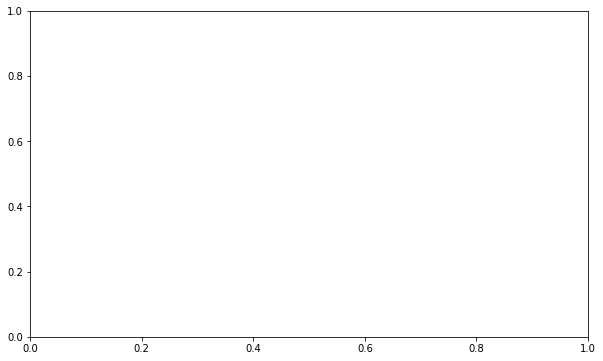

In [15]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['long'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['long'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()